170500096/170498071 [==============================] - 2s 0us/step
X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32

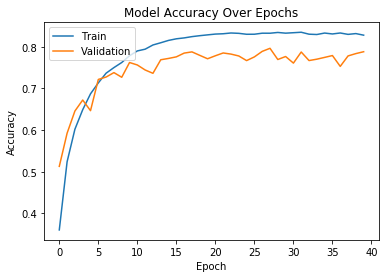

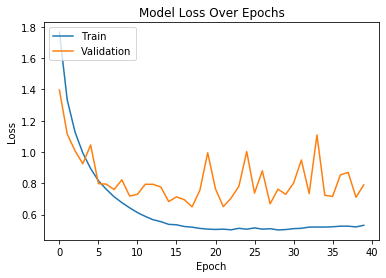

In [7]:
########################################
# CIFAR-10 CNN TRAINING WITH KERAS     #
# My notes & code                      #
########################################

#------------- IMPORTS ---------------------------------------------------#
from keras.datasets import cifar10 # gets the cifar10 images
from keras.utils import np_utils # converts integer labels into one-hot vectors
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D # convolutional and pooling layers for the CNNs
from keras.optimizers import SGD, Adam, RMSprop # optimizers

# For data augmentation
from keras.preprocessing.image import ImageDataGenerator

# For plotting
import matplotlib.pyplot as plt

# For insecure HTTPS context
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

#---------------------------NOTES---------------------------------------------
# CIFAR-10 is a dataset of 60,000 color images, each are 32x32 pixels.
# It has 10 possible classes (airplane, automobile, bird, cat, etc.).
#-----------------------------------------------------------------------------
 
########################################
# 1. SET CONSTANTS
########################################
# Image dimensions for CIFAR-10 ----> 32x32 pixels
IMG_CHANNELS = 3   # (R, G, B)
IMG_ROWS = 32
IMG_COLS = 32


# Model & training constants
BATCH_SIZE = 128       # how many images to process before updating the model
NB_EPOCH = 40          # total training epochs (runs)
NB_CLASSES = 10        # 10 classes in CIFAR-10 (airplane, automobile, bird, cat, etc.)
VERBOSE = 1            # display progress bars
VALIDATION_SPLIT = 0.2 # percent of training data used for validation
OPTIM = RMSprop()      # using RMSprop optimizer


########################################
# 2. LOADING DATASET
########################################
# Keras will download the dataset if not present on system.
# If SSL error, download manually.

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')


# --------------------------------------
# 3. PREPARE LABELS
# --------------------------------------
# Converts integer labels (0-9) to one-hot encoded vectors (of length 10).

Y_train = np_utils.to_categorical(y_train, NB_CLASSES) # remember, above NB_CLASSES = 10
Y_test = np_utils.to_categorical(y_test, NB_CLASSES)


# --------------------------------------
# 4. PRE-PROCESS THE DATA (NORMALIZATION)
# --------------------------------------
# Scale pixel values from [0, 255] to [0, 1] for easier & faster convergence.

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255


# --------------------------------------
# 5. BUILD THE CONVOLUTIONAL NEURAL NETWORK
# --------------------------------------
# Stack convolution/pooling layers, then flatten to dense layers.

model = Sequential()

#------------------ BLOCK 1 ------------------#
model.add(Conv2D(32, kernel_size=3, padding='same',
                 input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS)))
model.add(Activation('relu'))  # ReLU activation
model.add(Conv2D(32, kernel_size=3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25))       # drop 25% of neurons to reduce overfitting

# each of these blocks has two Conv2D layers, then a ReLU, then a pooling layer, and a droout
#

#------------------ BLOCK 2 ------------------#
model.add(Conv2D(64, kernel_size=3, padding='same'))
model.add(Activation('relu'))
# The old Keras syntax might use Conv2D(64, 3, 3), but the recommended way is:
model.add(Conv2D(64, kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))       # drop 25% again

#------------------ FLATTEN + DENSE LAYERS ------------------#
model.add(Flatten())           # Flatten 2D/3D features into 1D
model.add(Dense(512))          # fully connected layer with 512 neurons
model.add(Activation('relu'))
model.add(Dropout(0.5))        # 50% dropout for final dense layer
model.add(Dense(NB_CLASSES))   # output layer has NB_CLASSES=10 units
model.add(Activation('softmax'))  # softmax for classification


# --------------------------------------
# 6. COMPILE THE MODEL
# --------------------------------------
# Uses categorical crossentropy (standard in multi-class classification)
# and tracking accuracy
model.compile(loss='categorical_crossentropy', 
              optimizer=OPTIM, 
              metrics=['accuracy'])

# Summarizes model structure
model.summary()


# --------------------------------------
# 7. DATA AUGMENTATION
# --------------------------------------
# this code is not actually *using* datagen to train
# it's kinda defining and fitting it to the data.
# datagen = ImageDataGenerator(
#         featurewise_center=False,
#         samplewise_center=False,
#         featurewise_std_normalization=False,
#         samplewise_std_normalization=False,
#         zca_whitening=False,
#         rotation_range=0,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         horizontal_flip=True,
#         vertical_flip=False)
# datagen.fit(X_train)


# --------------------------------------
# 8. TRAIN MODEL
# --------------------------------------
# This call uses the raw X_train/Y_train directly, ignoring datagen.
# If you want to use data augmentation, see note below.
history = model.fit(X_train, Y_train,
                    batch_size=BATCH_SIZE,
                    epochs=NB_EPOCH,
                    validation_split=VALIDATION_SPLIT,
                    verbose=VERBOSE)

# NOTE: want to use the data augmentation?
# history = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
#                     steps_per_epoch=len(X_train)//BATCH_SIZE,
#                     epochs=NB_EPOCH,
#                     validation_data=(X_test, Y_test),
#                     verbose=VERBOSE)



########################################
# 9. EVALUATE ON TEST SET
########################################
score = model.evaluate(X_test, Y_test,
                       batch_size=BATCH_SIZE,
                       verbose=VERBOSE)
print("\nTest score:", score[0])      # test loss
print('Test accuracy:', score[1])     # test accuracy

########################################
# 10. SAVE MODEL ARCHITECTURE & WEIGHTS
########################################
# Useful if you want to reload or share your trained model
model_json = model.to_json()
open('cifar10_architecture.json', 'w').write(model_json)
model.save_weights('cifar10_weights.h5', overwrite=True)

########################################
# 11. PLOT TRAINING HISTORY
########################################
# IMPORTANT: In older Keras, 'acc'/'val_acc' might be the correct keys,
# but in newer TF/Keras, it's usually 'accuracy'/'val_accuracy'.
# Check your 'history.history.keys()' output to see what keys exist.
########################################

print(history.history.keys())

# If your history object has 'acc' and 'val_acc', use these lines:
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])

# If your history object has 'accuracy' and 'val_accuracy', use these:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#---------------------------------------#
# Similarly, plot the loss:
#---------------------------------------#
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Ethical and privacy concerns of this algorithm

I will use the example of the algorithm being able to distinguish faces that was suggested. 

The Institute of Electrical and Electronics Engineers (IEEE), an organization aimed at the advancement of technology, has stated a couple ethical concerns regarding facial recognition. First being that a widespread deployment of this type of program may lead to infringement on the right to individual privacy and autonomy, even the possibility of affecting free expressoin and association. This week a discussion prompt was meant to inspire conversation on bias in these sorts of programs, the IEEE goes on to say that current systems in place have exhibited lower accuracy in identifying women and people of colour. A good point that the IEEE also mentioned is the question of consent and transparency of the use over an individuals biometric data. It seems like this topic is more like a hydra than anything - one new technology appears and more ethical questions pop up. There must be some kind of balance to the individuals regarding personal autonomy and control over their own image. 

There are many, many, many more concerns over AI/ML and the ethical and legal complexities that seem married to it. Some governmental organizations like the EU and UN have begun adopting legal frameworks to protect citizens from the misuse of this new technology. The framework topically consists of "Consent and Transparency, Data Protection, Accuracy and Fairness, Limitations on Use, and Accountability and Redress" all of which seek to protect users and demographic groups from misuse. As we progress further with this new and rapidly evolving technology it is the responsibility of our government, providers, and independent users of AI/ML to ethically use it. The policymakers must act swiftly and within some capacity begin the process of protecting individuals, delaying this is only empowering the possibility, and reality, of misuse. In regards to locales adopting AI/ML for crimewatch and prevention, I think should be a yearly or bi-annual vote by the citizens on its use with full transparency of how its being used. Nothing of this critical nature to privacy and security should be off of the citizens' ballot - its important we know what's going on, I would see this as an extension of transparency on the government's behalf for public trust and relations. 

https://publicsafety.ieee.org/topics/ethical-considerations-in-the-use-of-facial-recognition-for-public-safety#:~:text=Another%20critical%20ethical%20issue%20is,women%20and%20people%20of%20color.